In [1]:
%matplotlib inline
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import sys
#sys.path.append("..") # Adds higher directory to python modules path.  
import seaborn as sns
import os.path
from scipy.stats import ttest_ind
import scipy.stats as stats
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics 
from scipy.stats import chi2_contingency
import missingno as msno
import Chi2test
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import xgboost
from plot_metric.functions import BinaryClassification

In [2]:
NoShow_Clean = pd.read_pickle('NoShow_Clean.pkl')

In [3]:
NoShow_Clean.head()

,Year,Season,WeekEnd,LastYear,LastSeason,LastWeekEnd,ClientType,Staff,BLastStaff,StaffCancType,...,ServicePrice,IsCanceled,LastIsCanceled,DaysRecency_cat,LastServicePrice_cat,LastServiceCost_cat,TotalClientCancellationsTillNow_cat,CancellationPcnt_cat,ServiceCost_cat,TotalClientBookingsTillNow_cat
0,2018,Summer,1,2018,Summer,1,LowCancClient,JOANNE,JOANNE,HighCancStaff,...,0.0,0,0,NewClient,NewClient,5.00-10.00,NewClient,NewClient,Unknown,NewClient
1,2018,Summer,1,2018,Summer,1,LowCancClient,JOANNE,BECKY,HighCancStaff,...,0.0,0,0,NewClient,0.00-102.00,0.00-5.00,NewClient,NewClient,Unknown,NewClient
2,2018,Summer,1,NewClient,NewClient,NewClient,LowCancClient,JOANNE,NewClient,HighCancStaff,...,0.0,0,NewClient,NewClient,NewClient,NewClient,NewClient,NewClient,Unknown,NewClient
3,2018,Summer,0,2018,Summer,0,LowCancClient,JOANNE,JJ,HighCancStaff,...,0.0,0,0,NewClient,0.00-102.00,0.00-5.00,NewClient,NewClient,Unknown,NewClient
4,2018,Summer,0,2018,Summer,0,LowCancClient,JOANNE,JOANNE,HighCancStaff,...,0.0,0,0,NewClient,NewClient,5.00-10.00,NewClient,NewClient,Unknown,NewClient


In [4]:
NoShow_Clean.dtypes

Year                                   category
Season                                 category
WeekEnd                                category
LastYear                               category
LastSeason                             category
LastWeekEnd                            category
ClientType                             category
Staff                                  category
BLastStaff                             category
StaffCancType                          category
BLastServiceCode                       category
BLastWomenMenService                   category
BLastColorCutService                   category
LastServiceCategory                    category
ServiceCode                            category
ServiceCancType                        category
WomenMenService                        category
ColorCutService                        category
ServiceCategory                        category
ServicePrice                            float64
IsCanceled                             c

# Feature selection

In [5]:
No_Show_dum = NoShow_Clean.copy()
as_is_features = ['IsCanceled','ServicePrice']


In [6]:
dummies_cols = [col for col in No_Show_dum.columns if col not in as_is_features]

In [7]:
No_Show_dum = pd.get_dummies(No_Show_dum[dummies_cols] )
No_Show_dum[as_is_features]=NoShow_Clean[as_is_features]

In [8]:
No_Show_dum.head()

,Year_2018,Year_2019,Season_Fall,Season_Spring,Season_Summer,Season_Winter,WeekEnd_0,WeekEnd_1,LastYear_2018.0,LastYear_2019.0,...,CancellationPcnt_cat_0.27-1.00,CancellationPcnt_cat_NewClient,ServiceCost_cat_0.00-0.27,ServiceCost_cat_0.27-1.00,ServiceCost_cat_Unknown,TotalClientBookingsTillNow_cat_0.00-0.27,TotalClientBookingsTillNow_cat_0.27-1.00,TotalClientBookingsTillNow_cat_NewClient,IsCanceled,ServicePrice
0,1,0,0,0,1,0,0,1,1,0,...,0,1,0,0,1,0,0,1,0,0.0
1,1,0,0,0,1,0,0,1,1,0,...,0,1,0,0,1,0,0,1,0,0.0
2,1,0,0,0,1,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0.0
3,1,0,0,0,1,0,1,0,1,0,...,0,1,0,0,1,0,0,1,0,0.0
4,1,0,0,0,1,0,1,0,1,0,...,0,1,0,0,1,0,0,1,0,0.0


# After multiple attempts, it turns out that the best alpha is 0.5.

In [9]:
cT = Chi2test.ChiSquare(No_Show_dum)
X_cols = No_Show_dum.drop(['IsCanceled'] , axis=1)
selected_cols = cT.get_significant_list(list_X=X_cols,colY='IsCanceled', alpha=0.5) 

In [10]:
selected_cols

['Season_Fall',
 'Season_Spring',
 'Season_Summer',
 'Season_Winter',
 'LastYear_2018.0',
 'LastYear_2019.0',
 'LastYear_NewClient',
 'LastSeason_Fall',
 'LastSeason_Spring',
 'LastSeason_Summer',
 'LastSeason_Winter',
 'LastSeason_NewClient',
 'LastWeekEnd_0.0',
 'LastWeekEnd_1.0',
 'LastWeekEnd_NewClient',
 'ClientType_HighCancClient',
 'ClientType_LowCancClient',
 'ClientType_MediumCancClient',
 'Staff_HOUSE',
 'Staff_JJ',
 'Staff_JOANNE',
 'Staff_KELLY',
 'Staff_SINEAD',
 'BLastStaff_BECKY',
 'BLastStaff_HOUSE',
 'BLastStaff_JOANNE',
 'BLastStaff_KELLY',
 'BLastStaff_SINEAD',
 'BLastStaff_TANYA',
 'BLastStaff_NewClient',
 'StaffCancType_HighCancStaff',
 'StaffCancType_LowCancStaff',
 'BLastServiceCode_CAS',
 'BLastServiceCode_CBAL',
 'BLastServiceCode_CCO',
 'BLastServiceCode_CHLPL',
 'BLastServiceCode_CT',
 'BLastServiceCode_FRI',
 'BLastServiceCode_SBD',
 'BLastServiceCode_SHCC',
 'BLastServiceCode_SHCW',
 'BLastServiceCode_NewClient',
 'BLastWomenMenService_Child',
 'BLastWomenM

In [11]:
No_Show_final = No_Show_dum[selected_cols + ['IsCanceled']]

In [12]:
No_Show_final.head()

,Season_Fall,Season_Spring,Season_Summer,Season_Winter,LastYear_2018.0,LastYear_2019.0,LastYear_NewClient,LastSeason_Fall,LastSeason_Spring,LastSeason_Summer,...,TotalClientCancellationsTillNow_cat_0.00-2.00,TotalClientCancellationsTillNow_cat_2.00-22.00,TotalClientCancellationsTillNow_cat_NewClient,CancellationPcnt_cat_0.00-0.27,CancellationPcnt_cat_0.27-1.00,CancellationPcnt_cat_NewClient,TotalClientBookingsTillNow_cat_0.27-1.00,TotalClientBookingsTillNow_cat_NewClient,ServicePrice,IsCanceled
0,0,0,1,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,1,0.0,0
1,0,0,1,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,1,0.0,0
2,0,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,1,0,1,0.0,0
3,0,0,1,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,1,0.0,0
4,0,0,1,0,1,0,0,0,0,1,...,0,0,1,0,0,1,0,1,0.0,0


# Split to train and test

In [13]:
X, y = No_Show_final[selected_cols], No_Show_final['IsCanceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
print(f'X_train.shape : {X_train.shape}\nX_test.shape : {X_test.shape}\ny_train.shape : {y_train.shape}\ny_test.shape : {y_test.shape}')

X_train.shape : (2211, 102)
X_test.shape : (553, 102)
y_train.shape : (2211,)
y_test.shape : (553,)


## Train will be splitted to dev and train using cross validation functions in the model creation

# Model selection

### For Grid Search:

In [15]:
#define constants for grid search
cv=2 #as the proportions of train and test
verbose=1

## Logistic regression

In [16]:
logModel = LogisticRegression()
logModel_params_ = {'penalty': ['l1', 'l2'],
                'max_iter': [100, 300, 1000],
                'tol': [1e-4, 1e-3, 1e-2],
                'C': [1e-2, 0.1, 1, 5, 10]}

In [17]:
logModel_m = GridSearchCV(logModel,
                          logModel_params_,
                          cv=cv,
                          n_jobs=4,
                          scoring = 'roc_auc',
                          verbose=verbose)
logModel_m.fit(X_train, y_train)

Fitting 2 folds for each of 90 candidates, totalling 180 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  55 tasks      | elapsed:    6.6s
[Parallel(n_jobs=4)]: Done 180 out of 180 | elapsed:    8.4s finished
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=4,
             param_grid={'C': [0.01, 0.1, 1, 5, 10],
                         'max_iter': [100, 300, 1000], 'penalty': ['l1', 'l2'],
                         'tol': [0.0001, 0.001, 0.01]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=1)

In [18]:
print ("AUC For GS LogistictRegression - Mean Validation Score: ",np.max(pd.DataFrame(logModel_m.cv_results_).mean_test_score))

AUC For GS LogistictRegression - Mean Validation Score:  0.7826388433326579


## Random Forest

In [19]:
rfModel = RandomForestClassifier()
rfModel_params_ = {'n_estimators':[2,10,25,100],
                   'max_features':[3,5,10,'auto','log2'],
                   'max_depth':[None,5,10],
                   'warm_start':[True,False]}
rfModel_m = GridSearchCV(rfModel,
                          rfModel_params_,
                          scoring = 'roc_auc',
                          cv=cv,
                          verbose=verbose)
rfModel_m.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 120 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:   18.7s finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [20]:
print ("AUC For GS RandomForestClassifier - Mean Validation Score: ",np.max(pd.DataFrame(rfModel_m.cv_results_).mean_test_score))

AUC For GS RandomForestClassifier - Mean Validation Score:  0.8135627969436853


## XGBoost

In [21]:
xgbModel = xgboost.XGBClassifier()
xgbModel_params_ ={'num_boost_round': [1000],
                'early_stopping_rounds': [10],
                'booster': ['gbtree', 'gblinear'],
                'max_depth': [3, 5, 7],
                'n_estimators': [50, 100, 200, 400],
               'objective':['binary:logistic']}
xgbModel_m = GridSearchCV(xgbModel,
                          xgbModel_params_,
                          cv=cv,
                          n_jobs=4,
                          scoring = 'roc_auc',
                          verbose=verbose)
xgbModel_m.fit(X_train, y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed:   43.6s finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constrai...
                                     subsample=None, tree_method=None,
                                     validate_parameters=False,
                                     verbosity=None),
             iid='warn', n_jobs=4,
             param_grid={'booster': ['gbtree', 'gblinear'],
                         'early_stopp

In [22]:
print ("AUC For GS XGBoostClassifier - Mean Validation Score: ",np.max(pd.DataFrame(xgbModel_m.cv_results_).mean_test_score))

AUC For GS XGBoostClassifier - Mean Validation Score:  0.8118270158383681


# SVM

In [23]:
svmModel = SVC(probability=True)

In [24]:
svmModel_params_ = {'C': [0.001, 0.01, 0.1, 1, 10],
                    'gamma' : [0.001, 0.01, 0.1, 1]}
svmModel_m = GridSearchCV(svmModel,
                          svmModel_params_,
                          cv=cv,
                          n_jobs=4,
                          scoring = 'roc_auc',
                          verbose=verbose)

In [25]:
svmModel_m.fit(X_train, y_train)

Fitting 2 folds for each of 20 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:   15.3s finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=4,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'gamma': [0.001, 0.01, 0.1, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=1)

In [26]:
print ("AUC For GS SVM - Mean Validation Score: ",np.max(pd.DataFrame(svmModel_m.cv_results_).mean_test_score))

AUC For GS SVM - Mean Validation Score:  0.7529087967108391


## The best Mean Validation AUC scores are for: Random Forest, XGBoost
## The chosen model will be the ensemble of Random Forest and XGBoost

In [27]:
xgb_test_preds = xgbModel_m.predict_proba(X= X_test)[:,1]

In [28]:
rfModel_test_preds = rfModel_m.predict_proba(X= X_test)[:,1]

In [29]:
ensemble_rf_xgb_preds = np.column_stack((xgb_test_preds*0.9, rfModel_test_preds*0.1)).mean(axis=1)

In [30]:
print ("AUC For GS ensembel-RF-XGB - test: ",metrics.roc_auc_score(y_test,ensemble_rf_xgb_preds))

AUC For GS ensembel-RF-XGB - test:  0.7974628879892037


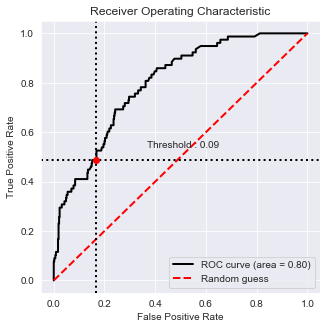

In [31]:
# Visualisation with plot_metric
bc = BinaryClassification(y_test,ensemble_rf_xgb_preds, labels=["NotCanceled", "Canceled"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve(threshold=0.09)
plt.show()

In [32]:
pd.crosstab(y_test,(xgb_test_preds>0.09)*1)

col_0,0,1
IsCanceled,,
0,322,153
1,19,59
